In [19]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib inline
from matplotlib.colors import LogNorm
from matplotlib import cm
import scipy.ndimage

## Part 1: Creation of the fields

### Creation of the mesh

In [20]:
Nx = 600
Ny = 400
X = np.linspace(0,1,num=Nx)
Y = np.linspace(0,1,num=Ny)
xv, yv = np.meshgrid(X, Y)

### Complex image to reconstruct
We generate a speckle pattern 

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter
grainSize = 20;
temp  = np.random.rand(Ny,Nx)-.5+np.random.rand(Ny,Nx)*1j-0.5j
image_sig = scipy.ndimage.filters.gaussian_filter(temp.real, grainSize/2)+1j*scipy.ndimage.filters.gaussian_filter(temp.imag, grainSize/2)
image_sig = image_sig/np.abs(image_sig)

/tmp/ipykernel_1654991/821633559.py:5: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  image_sig = scipy.ndimage.filters.gaussian_filter(temp.real, grainSize/2)+1j*scipy.ndimage.filters.gaussian_filter(temp.imag, grainSize/2)


### Build the reference image (tilted plane wave)

In [22]:
kx = 400
image_ref = np.exp(1j*xv*kx)

### Intensity of the interference pattern

In [23]:
I = np.abs(image_ref+image_sig)**2;

### Display the phase images and the interference pattern

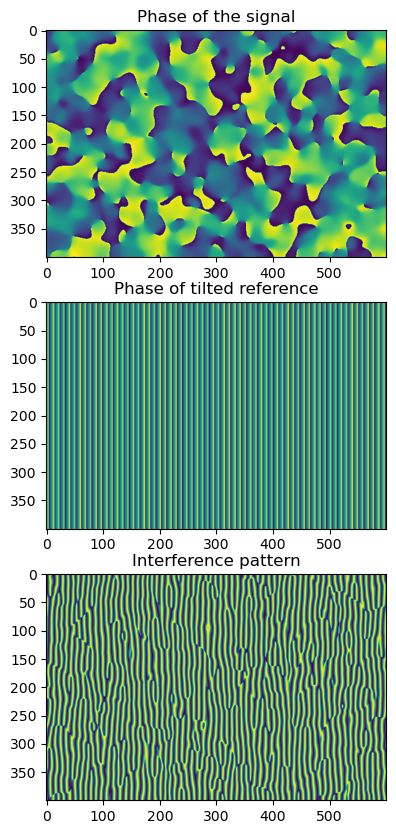

In [24]:
plt.figure(figsize = (7,10))
plt.subplot(311)
plt.imshow(np.angle(image_sig))
plt.title('Phase of the signal')
plt.subplot(312)
plt.imshow(np.angle(image_ref))
plt.title('Phase of tilted reference')
plt.subplot(313)
plt.imshow(I)
plt.title('Interference pattern')
plt.show()

## Part 2: Calculation of the field in the Fourier plane

### Fourier transform of the intensity pattern

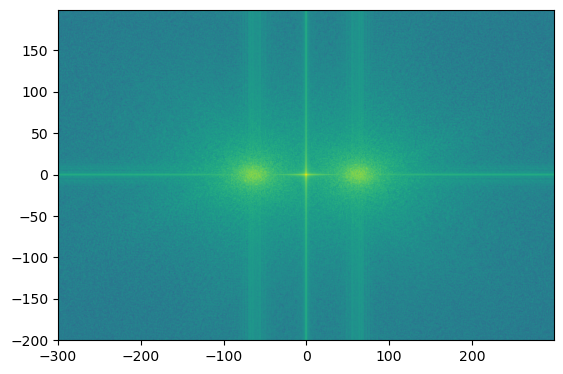

In [25]:
nb = 5;  # if nb = 1 =, no zero padding / nb > 1, add zeros in the Fourier tranform, see the help of fft2
Fh = np.fft.fftshift(np.fft.fft2(I,s=[Ny*nb,Nx*nb]))

# Display it
# %matplotlib inline
plt.figure()
from matplotlib.colors import LogNorm

plt.imshow(np.abs(Fh+0.01),
           extent=[-0.5*Nx,0.5*Nx-1,-0.5*Ny,0.5*Ny-1],
           norm=LogNorm(vmin=0.01, vmax=np.abs(Fh).max()))
plt.show()



In [26]:
## Create the vector of the spatial frequencies
SfreqX = np.arange(-0.5*Nx,0.5*Nx,1/nb)
SfreqY = np.arange(-0.5*Ny,0.5*Ny,1/nb)

## Frequency grid
[Sx,Sy] = np.meshgrid(SfreqX,SfreqY)

## Part 3: Filtering in the Fourier plane

### Select a window arounf the -1 order

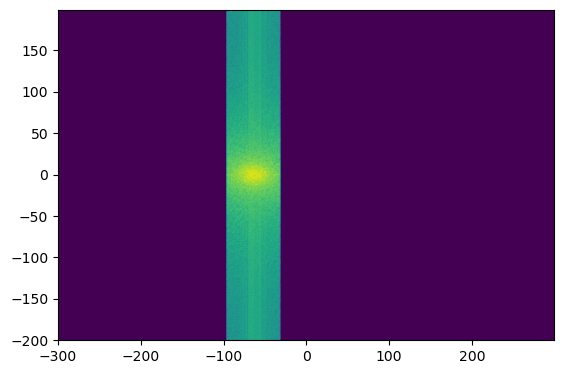

In [27]:
## Now we want to do a filtering of the spatial frequencies to keep only the
## -1 order
freq = kx/(2*np.pi)        # center frequency of the first orders
width = freq               # width of the filtering window

## First create the mask, we want to conseve the spatial frequencies around minus the carrier frequency ('-freq') with a window of size 'width'
Mask1 = (Sx > -freq-width/2)*(Sx < -freq+width/2)

## We get the field in the Fourier plane after filtering
Fh2 = Fh*Mask1

## Display it
plt.figure()
plt.imshow(np.abs(Fh2+0.01),
           extent=[-0.5*Nx, 0.5*Nx - 1, -0.5*Ny, 0.5*Ny - 1],
           norm=LogNorm(vmin=0.01, vmax=np.abs(Fh2).max()))
plt.show()

### Shift the frequencies to center the order around the 0 frequency

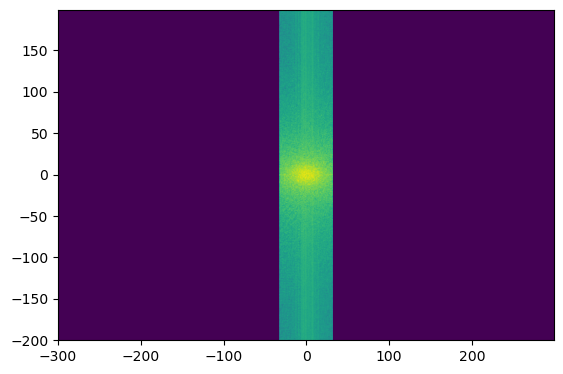

In [30]:
## We shift the spatial frequencies around zero to remove the effect of the angular tilt due to -1 order
#Mask2 = (Sx > -width/2)*(Sx < width/2)  # window centered around 0 of width 'width' 
I1 = np.nonzero(Mask1)                  # gets the indices corresponding to Mask1
Fh3 = np.zeros(Fh.shape)+np.zeros(Fh.shape)*1j
# We copy the -1 order centered to the zero frequency
Fh3[I1[0],(I1[1]+np.round(freq*nb)+1).astype(int)] = Fh2[I1[0],I1[1]]

# Display it
plt.figure()
plt.imshow(np.abs(Fh3+0.01),
           extent=[-0.5*Nx, 0.5*Nx - 1, -0.5*Ny, 0.5*Ny - 1],
           norm=LogNorm(vmin=0.01, vmax=np.abs(Fh3).max()))
plt.show()

## Part 4: Field in the plane conjugated with the SLM


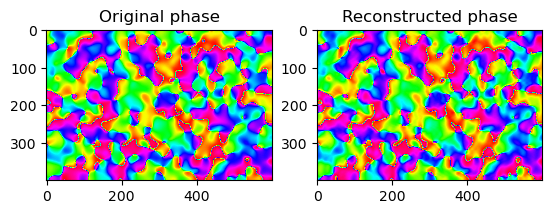

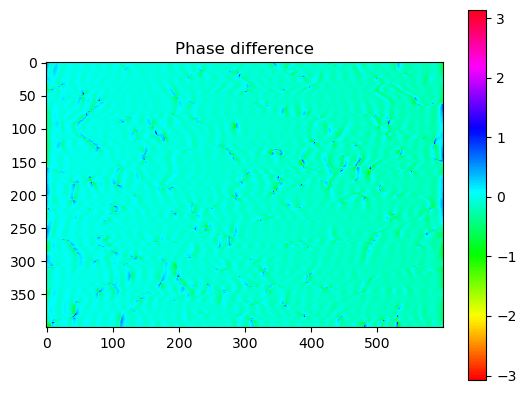

In [32]:
## Get the field after the second length
tempIFT = np.fft.ifft2(np.fft.ifftshift(Fh3))
finalField = tempIFT[0:Ny,0:Nx]

## Display the target phase map and the generated one
plt.figure()
plt.subplot(121)
plt.imshow(np.angle(image_sig),cmap=cm.hsv);
plt.title('Original phase')
plt.subplot(122)
plt.imshow(np.angle(finalField),cmap=cm.hsv);
plt.title('Reconstructed phase')

plt.figure()
plt.imshow(np.angle(image_sig/finalField),cmap=cm.hsv);
plt.title('Phase difference')
plt.colorbar()
plt.show()